----------
***Vizualization Data***
----------
----------
Vizualize data into several model,
- **Waveform**
- **bold**
- **MFCC (Mel Frequency Cepstrum Coefficients)**
- **dBFS (Decibels relative to Full Scale)**

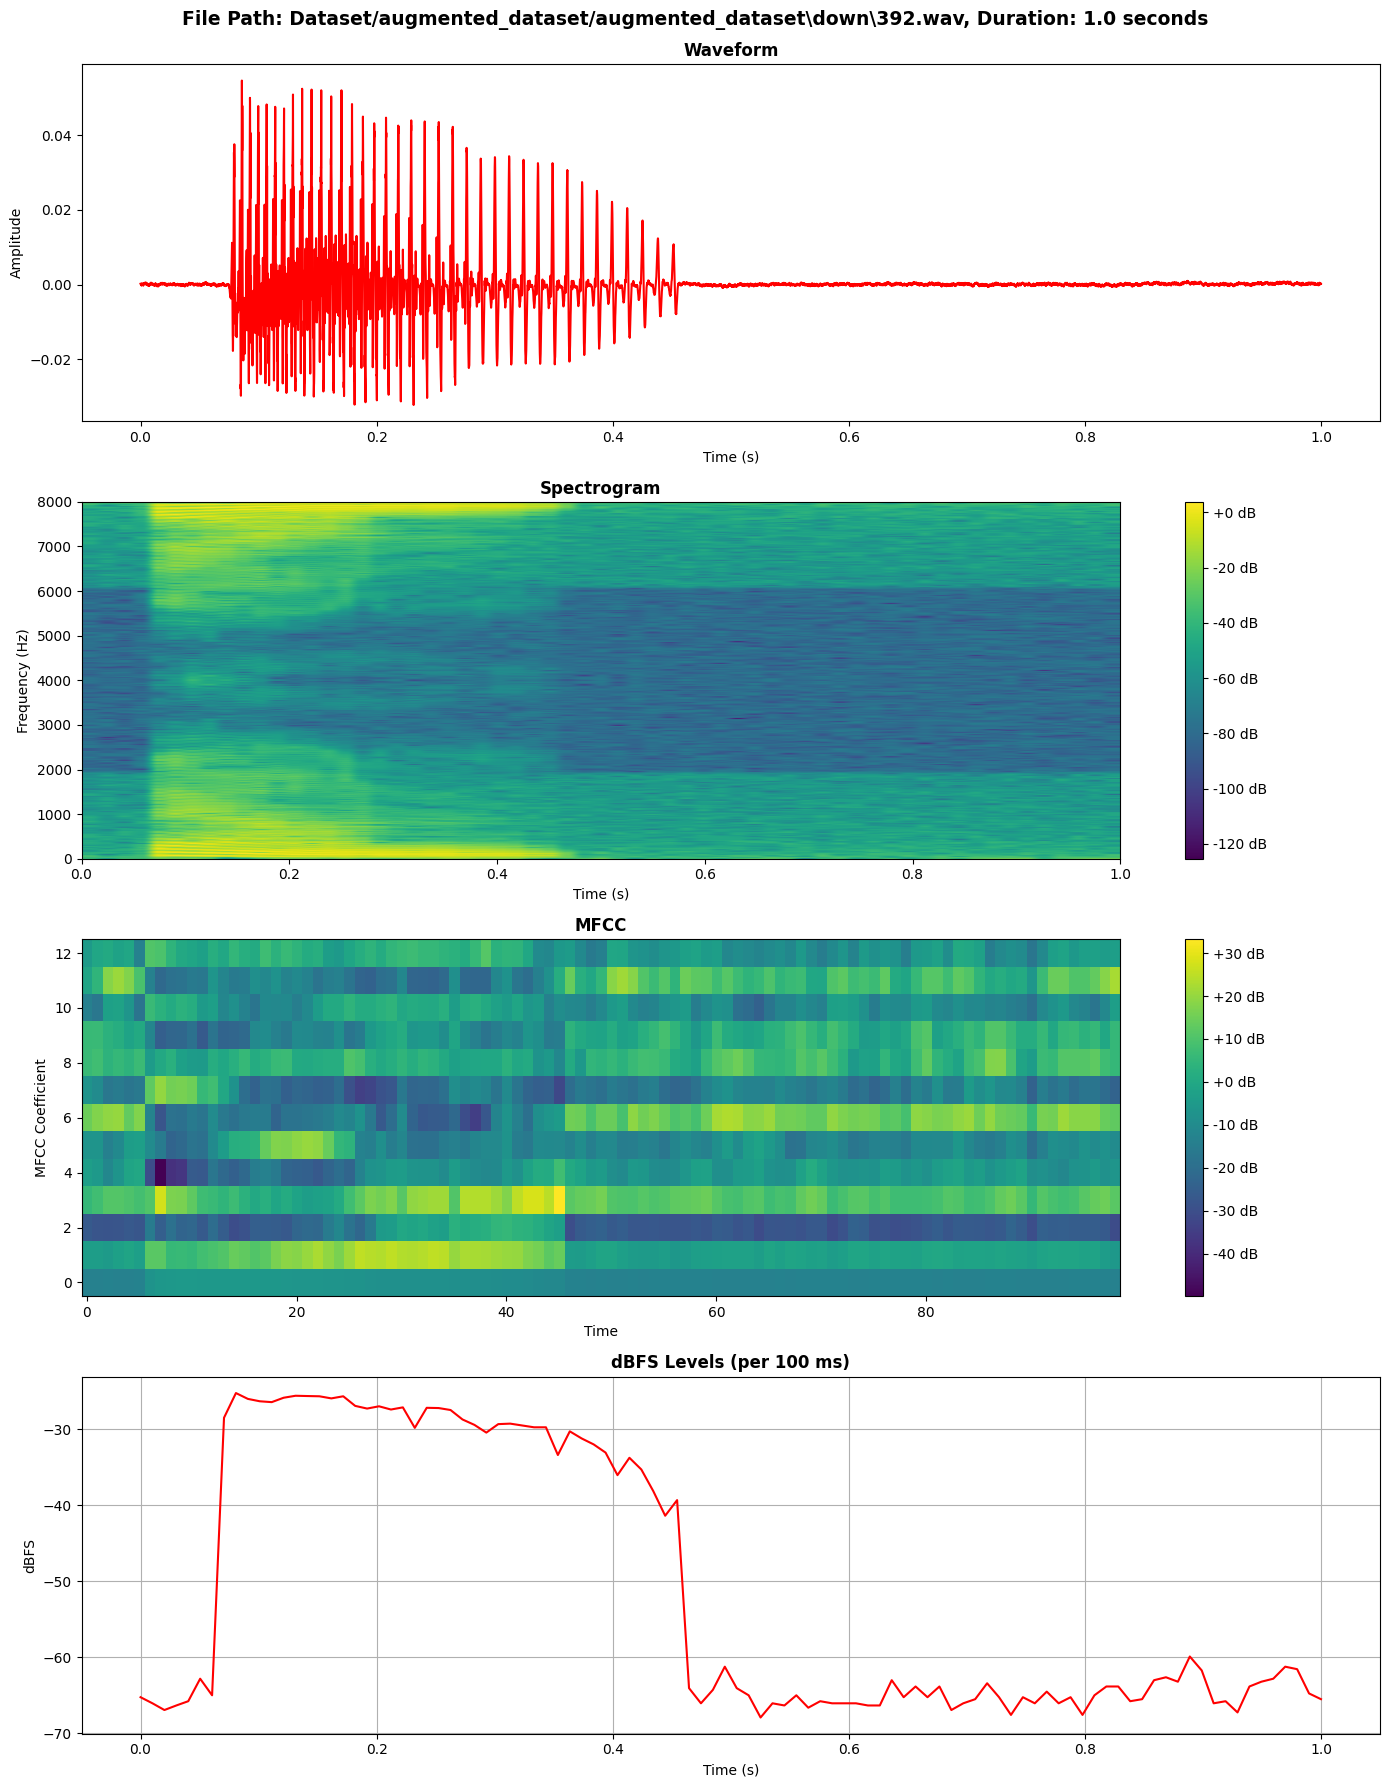

In [2]:
import os
import soundfile as sf
import numpy as np
from python_speech_features import mfcc
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from scipy.signal import get_window
import random

def calculate_spectrogram(audio,N=512, hop_length=256):
    window = get_window('hann', N)
    spec = np.abs(np.array([np.fft.fft(window * audio[i:i+N]) for i in range(0, len(audio)-N, hop_length)]))
    spec = 20 * np.log10(spec)
    return spec

def plot_audio(file_path):
    try:
        # Load audio file
        audio, sr = sf.read(file_path)
        
        # Normalize audio
        normalized_audio = normalize(audio.reshape(1, -1)).reshape(-1)
        
        # Calculate dBFS levels
        interval_size = int(sr / 100)
        dbfs_levels = [20 * np.log10(np.max(np.abs(normalized_audio[i:i+interval_size]))) 
                    for i in range(0, len(normalized_audio), interval_size)]
        
        # Extract MFCC features
        mfcc_features = mfcc(normalized_audio, sr)

        duration = len(normalized_audio) / sr
        
        # Visualize audio
        plt.figure(figsize=(14, 18))
        plt.suptitle(f'File Path: {file_path}, Duration: {duration} seconds', fontsize=13.5, fontweight='bold', y=0.99, ha='center')
        
        # Plot waveform
        plt.subplot(4, 1, 1)
        plt.plot(np.linspace(0, len(normalized_audio) / sr, len(normalized_audio)), normalized_audio, color='r')
        plt.title('Waveform', fontsize=12, fontweight='semibold')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        
        # Calculate and plot spectrogram
        plt.subplot(4, 1, 2)
        spec = calculate_spectrogram(normalized_audio)
        plt.imshow(spec.T, aspect='auto', origin='lower', extent=[0, len(normalized_audio) / sr, 0, sr / 2])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram', fontsize=12, fontweight='semibold')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        
        
        # Plot MFCC features
        plt.subplot(4, 1, 3)
        plt.imshow(mfcc_features.T, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title('MFCC', fontsize=12, fontweight='semibold')
        plt.xlabel('Time')
        plt.ylabel('MFCC Coefficient')
        

        # Plot dBFS levels
        plt.subplot(4, 1, 4)
        duration = len(normalized_audio) / sr
        plt.plot(np.linspace(0, duration, len(dbfs_levels)), dbfs_levels, color='red')
        plt.xlabel('Time (s)')
        plt.ylabel('dBFS')
        plt.title('dBFS Levels (per 100 ms)', fontsize=12, fontweight='semibold')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Paths to the dataset folders
folders = ['right', 'left', 'up', 'down']
dataset_folders = [
    "Dataset/augmented_dataset/augmented_dataset",
    "Dataset/augmented_dataset_verynoisy/augmented_dataset_verynoisy"
]

# Randomly select a file
random_folder = random.choice(dataset_folders)
random_subfolder = random.choice(folders)
folder_path = os.path.join(random_folder, random_subfolder)
files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]
random_file = random.choice(files)
file_path = os.path.join(folder_path, random_file)

# Plot the randomly selected file
plot_audio(file_path)

----------
***Load and Preprocessing Dataset***
----------
----------

In [7]:
import os
import soundfile as sf
import numpy as np
from python_speech_features import mfcc
from sklearn.preprocessing import normalize
from joblib import Parallel, delayed

# Paths to the dataset folders
folders = ['right', 'left', 'up', 'down']
dataset_folders = ["Dataset/augmented_dataset/augmented_dataset", "Dataset/augmented_dataset_verynoisy/augmented_dataset_verynoisy"]

# Output folder for preprocessed files
output_folder = "Dataset/preprocessed_data_combined"
# Get a list of all files in the output folder
file_list = os.listdir(output_folder)

# Iterate over the files and delete them
for file_name in file_list:
    file_path = os.path.join(output_folder, file_name)
    os.remove(file_path)

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Function to preprocess audio
def preprocess_audio(file_path):
    try:
        # Load audio file
        audio, sr = sf.read(file_path)
        
        # Normalize audio
        normalized_audio = normalize(audio.reshape(1, -1)).reshape(-1)
        
        # Extract MFCC features
        mfcc_features = mfcc(normalized_audio, sr)
        
        return mfcc_features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to process files
def process_files(dataset_folder, folder, output_folder):
    folder_path = os.path.join(dataset_folder, folder)
    files = [f for f in os.listdir(folder_path) if f.endswith(".wav")]

    for file in files:
        file_path = os.path.join(folder_path, file)
        mfcc_features = preprocess_audio(file_path)
        if mfcc_features is not None:
            label = folder
            output_file_path = os.path.join(output_folder, f"{os.path.basename(dataset_folder)}_{folder}_{file.replace('.wav', '.npy')}")
            np.save(output_file_path, {'mfcc': mfcc_features, 'label': label})

# Process each dataset folder
for dataset_folder in dataset_folders:
    # Process each subfolder in parallel
    Parallel(n_jobs=-1)(delayed(process_files)(dataset_folder, folder, output_folder) for folder in folders)


In [8]:
files = os.listdir(output_folder)
num_files = len(files)
print(f"Number of files that have been loaded and processed in  {output_folder}: {num_files}")

Number of files that have been loaded and processed in  Dataset/preprocessed_data_combined: 10272


In [13]:
import os
import numpy as np

# Path to the folder containing the preprocessed data
output_folder = "Dataset/preprocessed_data_combined"

# List all files in the output folder
files = os.listdir(output_folder)

# Pick a random file
random_file = np.random.choice(files)

# Load the data
data = np.load(os.path.join(output_folder, random_file), allow_pickle=True).item()

# Extract the MFCC features and label
mfcc_features = data['mfcc']
label = data['label']

# Print all information
print(f"File: {random_file}")
print(f"Label: {label}")
print(f"MFCC Shape: {mfcc_features.shape}")
print(f"MFCC Features:\n{mfcc_features}")


File: augmented_dataset_verynoisy_right_1422.npy
Label: right
MFCC Shape: (99, 13)
MFCC Features:
[[ -4.79943705 -11.79917008 -40.34614186 ... -11.43944415  12.20055096
   -7.46346795]
 [ -5.07659582  -2.21353067 -47.8982947  ... -14.09449407  10.49409923
  -13.32458992]
 [ -5.05651725  -1.92345968 -46.87169252 ... -20.10124004  13.61345002
  -13.90244276]
 ...
 [ -4.80320994  -4.40289431 -47.47634564 ... -20.92090515   1.82212166
  -11.78202608]
 [ -4.89899791  -9.95734098 -45.41112589 ... -16.52433591   1.05972077
  -11.5563902 ]
 [ -5.03150545  -4.45884855 -47.2162544  ... -11.40274301  12.13628272
   -8.18766841]]


----------
***Model Setup***
----------
----------

In [14]:
import os
import numpy as np
from joblib import Parallel, delayed, dump
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data_folder = "Dataset/preprocessed_data_combined"
files = os.listdir(data_folder)

def load_data(file):
    data = np.load(os.path.join(data_folder, file), allow_pickle=True).item()
    return data['mfcc'][:, :13], data['label']

# Load data in parallel
result = Parallel(n_jobs=-1)(delayed(load_data)(file) for file in files)

# Separate features and labels
X, y = zip(*result)
X = np.array(X)
y = np.array(y)

# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape the data for compatibility with classifiers
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)


In [16]:
# Train and evaluate models
models = {
    "SVM": SVC()
}

# Results dictionary to store training, validation, and test accuracies
results = {"Training": {}, "Validation": {}, "Test": {}}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Training accuracy
    y_train_pred = model.predict(X_train_scaled)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    results["Training"][name] = train_accuracy

    # Validation accuracy
    y_val_pred = model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    results["Validation"][name] = val_accuracy

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"Mean CV score for {name}: {np.mean(cv_scores)}")

    # Test accuracy
    y_test_pred = model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    results["Test"][name] = test_accuracy

    print(f"Test Accuracy for {name}: {test_accuracy}")
    print(classification_report(y_test, y_test_pred))
    print()

Training SVM...
Mean CV score for SVM: 0.970302345667309
Test Accuracy for SVM: 0.9688564476885645
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       471
           1       0.99      0.97      0.98       556
           2       0.98      0.95      0.96       560
           3       0.91      0.99      0.95       468

    accuracy                           0.97      2055
   macro avg       0.97      0.97      0.97      2055
weighted avg       0.97      0.97      0.97      2055




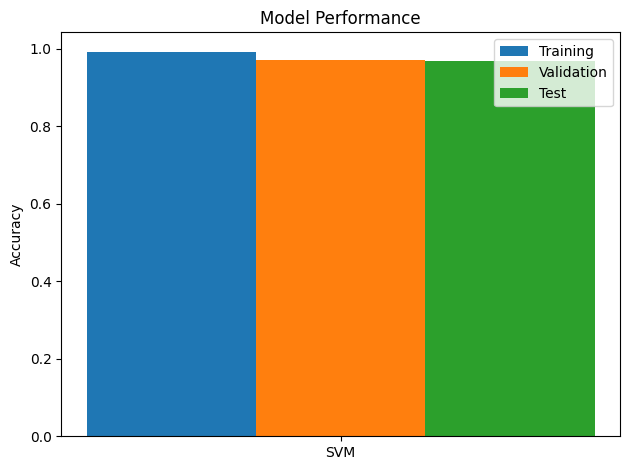

In [17]:
# Plotting the results
labels = list(results["Training"].keys())
training_accuracies = list(results["Training"].values())
validation_accuracies = list(results["Validation"].values())
test_accuracies = list(results["Test"].values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, training_accuracies, width, label='Training')
rects2 = ax.bar(x, validation_accuracies, width, label='Validation')
rects3 = ax.bar(x + width, test_accuracies, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

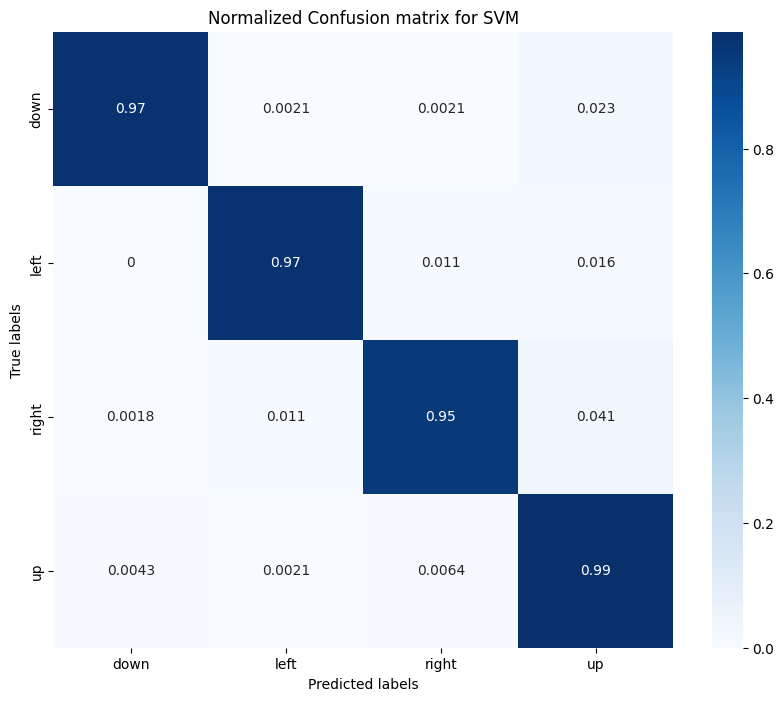

In [18]:
# Plot confusion matrix with probabilities
cm = confusion_matrix(y_test, y_test_pred, normalize='true')  # Normalize along the true label axis
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Normalized Confusion matrix for {name}')
plt.show()

In [19]:
model_filename = f"{name}_model.joblib"
dump(model, model_filename)
print(f"Saved model as {model_filename}")

Saved model as SVM_model.joblib


In [20]:
# Save the LabelEncoder
label_encoder_filename = f"label_encoder.joblib"
dump(label_encoder, label_encoder_filename)
print(f"Saved LabelEncoder as {label_encoder_filename}")

Saved LabelEncoder as label_encoder.joblib
